# Data Centric XAI part - 2
## CHAPTER 03 - *Data Centric Approaches*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

This is part 2 of the tutorial part of Chapter 03 (Data Centric XAI). The part 1 can be viewed from the [part1 notebook](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter03/Data_Centric_XAI_part_1.ipynb). In this notebook, we will try to view the effect of adversarial attacks on inference data and certain ways to detect it.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn numba==0.53 adversarial-robustness-toolbox torch sewar

### Loading the modules

In [77]:
import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniLInfMethod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from IPython.display import Image, display

from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions


In this example, we are going to use a pre-trained ImageNet model from TensorFlow as we are simulating the situation of having a trained model and the inference data is exposed to adversarial attacks. We are going to make use of the [adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox) Python framework to generate the adversarial examples and use [sewar](https://sewar.readthedocs.io/en/latest/) a Python framework for image quality assessment. An image exposed to adversrial attack will have a degration in its quality or deviation in the statistical properties on the original image and hence we are going to detect adversarial example by using this framework. 

### Loading the data

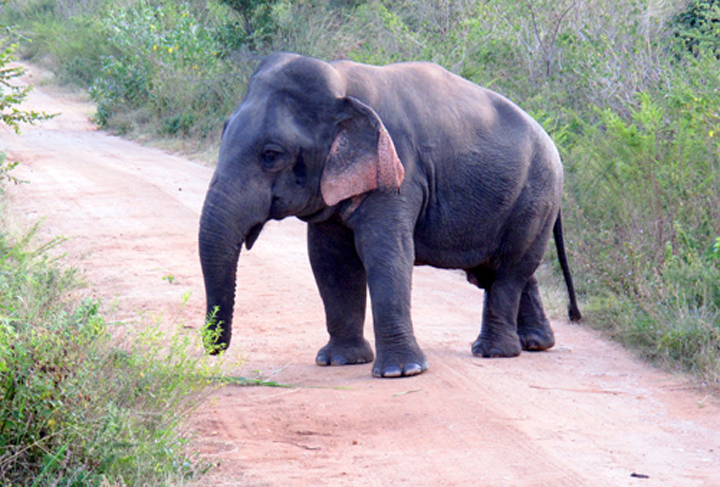

In [2]:
def load_image_data_from_url(url):
    '''
    Function to load image data from online
    '''
    # The local path to our target image
    image_path = keras.utils.get_file(
    "inference_data.jpg", url
    )

    display(Image(image_path))
    return image_path

image_path = load_image_data_from_url(url = 'https://i.imgur.com/JT7SP0M.jpeg')

In [3]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

### Defining the model

For this example, we are not training a model from scratch, but rather defining a pretrained Tensorflow Xception model to showcase the impact of Adversarial attacks in the inference data.

In [65]:
model = Xception(weights="imagenet")

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]
    
pred_orig = get_model_predictions(normalized_img)

The predicted class is : Indian_elephant


### Generating Adevrsarial Examples using Adversarial-Robustness-Toolbox

In [27]:
art_model = KerasClassifier(model=model, clip_values=(0, 1))

#### Using FGSM

In [66]:
attack_fgsm = FastGradientMethod(art_model, eps = 0.1)
adv_images_fgsm = attack_fgsm.generate(x = normalized_img)
pred_fgsm = get_model_predictions(adv_images_fgsm)

The predicted class is : tusker


#### Using C&W method

In [69]:
attack_cw = CarliniLInfMethod(art_model, max_iter=100, verbose=True)
adv_images_cw = attack_cw.generate(x = normalized_img, verbose=True)
pred_cw =get_model_predictions(adv_images_cw)

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

The predicted class is : tusker


#### Using PGD

In [67]:
norm = 2
attack_pgd = ProjectedGradientDescent(art_model, eps = 0.1, verbose=True)
adv_images_pgd = attack_pgd.generate(x = normalized_img, verbose=True)
pred_pgd = get_model_predictions(adv_images_pgd)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

The predicted class is : maze


### Displaying the adversarial examples

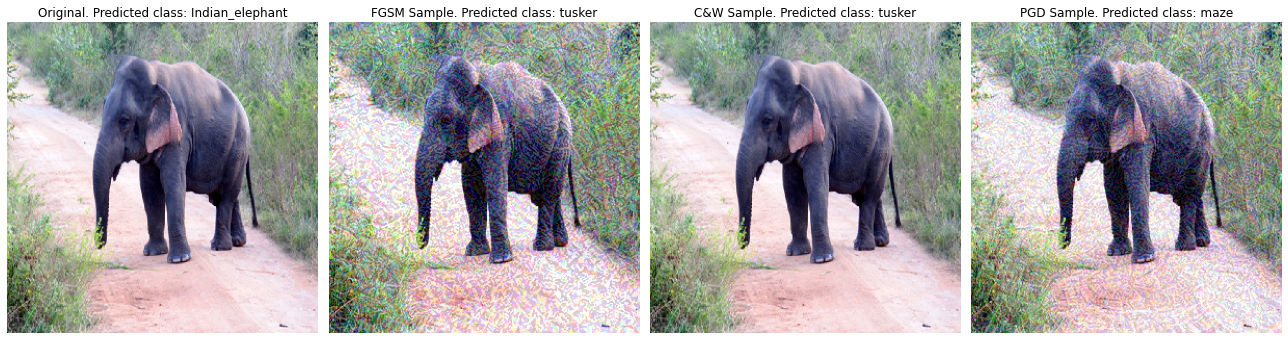

In [75]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,12))

#fig.suptitle('Adversarial samples with the original')
ax1.imshow(normalized_img[0])
ax1.set_title(f'Original. Predicted class: {pred_orig}')
ax1.set_axis_off()
ax2.imshow(adv_images_fgsm[0])
ax2.set_title(f'FGSM Sample. Predicted class: {pred_fgsm}')
ax2.set_axis_off()
ax3.imshow(adv_images_cw[0])
ax3.set_title(f'C&W Sample. Predicted class: {pred_cw}')
ax3.set_axis_off()
ax4.imshow(adv_images_pgd[0])
ax4.set_title(f'PGD Sample. Predicted class: {pred_pgd}')
ax4.set_axis_off()
plt.tight_layout()

### Comparing the image quality of the adversarial examples with the original image

In [106]:
# PSNR
# SSIM
# UQI
# Calculate the image quality scores
image_quality_df = pd.DataFrame(columns = ['Sample', 'PSNR', 'ERGAS', 'UQI'])
# Original Sample
image_quality_dict = {'Sample' : 'Original', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (normalized_img*255).astype('int')),
                     'ERGAS' : ssim((normalized_img[0]*255).astype('int'), (normalized_img[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], normalized_img[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# FGSM Sample
image_quality_dict = {'Sample' : 'FGSM', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_fgsm*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_fgsm[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_fgsm[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# C&W Sample
image_quality_dict = {'Sample' : 'C&W', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_cw*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_cw[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_cw[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
# PGD
image_quality_dict = {'Sample' : 'PGD', 
                     'PSNR' : psnr((normalized_img*255).astype('int'), (adv_images_pgd*255).astype('int')),
                     'ERGAS' : ergas((normalized_img[0]*255).astype('int'), (adv_images_pgd[0]*255).astype('int')),
                     'UQI' : uqi(normalized_img[0], adv_images_pgd[0])
                     }
image_quality_df = image_quality_df.append(image_quality_dict, ignore_index = True)
display(image_quality_df)    

,Sample,PSNR,ERGAS,UQI
0,Original,inf,"(1.0, 1.0)",1.000000
1,FGSM,158.762624,9038.356295,0.970892
2,C&W,184.680289,430.885103,0.999962
3,PGD,160.478128,7453.775587,0.979038


### Suggestions to improve adversarial robustness

- approach 1
- approach 2
- approach 3

### Final Thoughts

In this notebook, we have learnt how the deepchecks framework can be effectively used to perform data-centric explanability methods. For certain method, if the framework does not support any built-in out-of-the-box api to implement the concept, we can definitely go with our custom approach similar to what we have seen in the Data Profiling section. Overall, detecting issues related to data consistency like data drifts, data leakage, data purity like missing values, duplicate values, outliers, and data forecasting using model evaluation metrics are certain essential measures that provides valuable explainability to our models and algorithms surrounding the underlying dataset.

## Reference

1. UCI Machine Learning Repository -https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
2. Deepcheck Open Source Python Framework - https://deepchecks.com/
3. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073